### This notebook can be run localy
Here we take a first look at the data, perform some pre-selection, resize the images to 200x200 pixels and save those resized images as `hdf5` files (split into training and tesating sets). 

In [13]:
import os
import numpy as np
np.random.seed(1338)

from PIL import Image
import h5py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams.update({
    "figure.constrained_layout.use" : True,
    "font.size" : 18,
    "figure.figsize" : (7, 5)
})

In [14]:
path = "../Flowers299/"
flowers = [
    "BeeBalm",
    "Black-eyedSusan",
    "BlanketFlower",
    "BleedingHeart",
    "ButterflyBush",
    "Dahlia",
    "FrangipaniFlower",
    "GrapeHyacinth",
    "MargueriteDaisy",
    "Trillium",
    "Waterlilies"
]

if not os.path.isdir("data/"):
    os.mkdir("data/")

#  Inspect dataset

In [15]:
shapes = []
images = []
for flower in flowers:
    for entry in os.scandir(path + f"{flower}/"):
        im = np.array(Image.open(entry.path))
        images.append(im)
        shapes.append(im.shape[:2])
        
shapes = np.array(shapes)
ratio = shapes[:,0] / shapes[:,1]

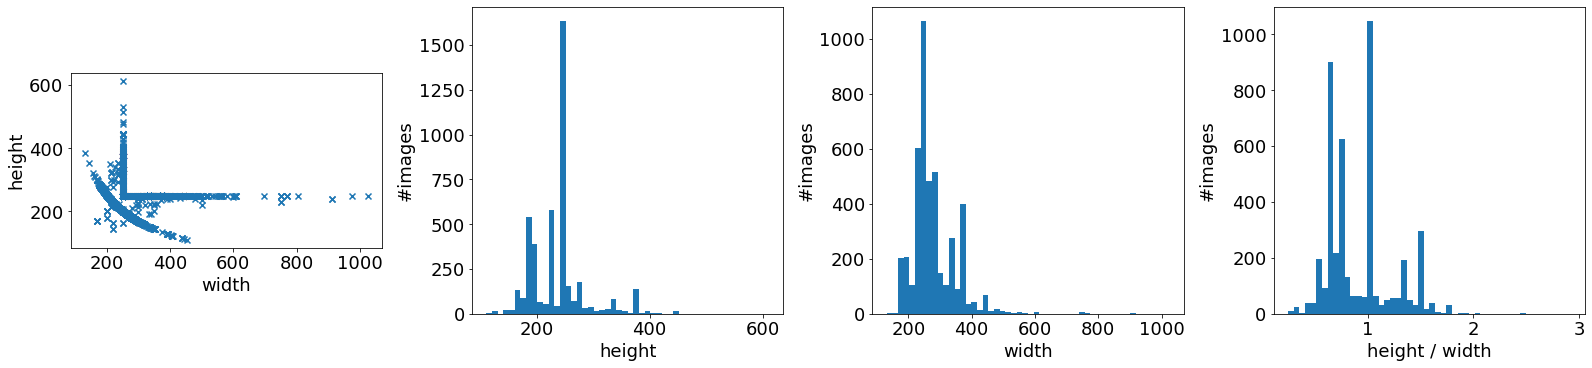

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))
axs[0].scatter(shapes[:,1], shapes[:,0], marker="x")
axs[0].set(
    xlabel = "width",
    ylabel = "height",
    aspect = 1
)
for ax, value, label in zip(axs[1:], 
                            [shapes[:,0], shapes[:,1], ratio],
                            ["height", "width", "height / width"]):
    ax.hist(value, bins=50, histtype="stepfilled")
    ax.set(
        xlabel = label,
        ylabel = "#images",
        aspect = "auto"
    )

/home/lukasbeiske/.local/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


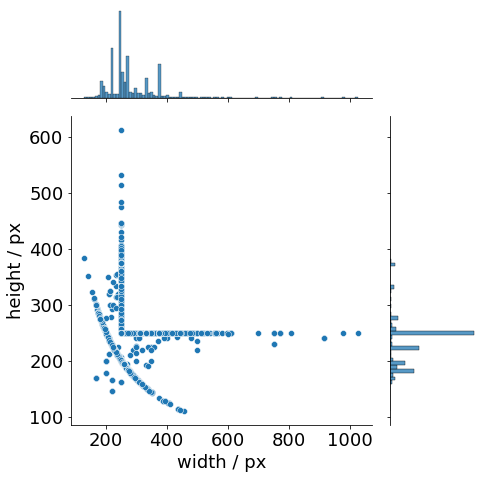

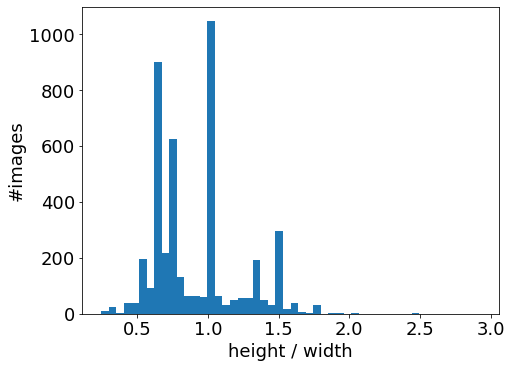

In [18]:
# same as above using seaborn
df_shapes = pd.DataFrame({
    "height / px" : shapes[:,0],
    "width / px" : shapes[:,1]
})

sns.jointplot(x=df_shapes["width / px"], y=df_shapes["height / px"], kind="scatter", height=7, ratio=3).savefig("data/width_vs_height.pdf")
fig, ax = plt.subplots()
ax.hist(ratio, bins=50, histtype="stepfilled")
ax.set(
    xlabel = "height / width",
    ylabel = "#images",
)
fig.savefig("data/ratio_hist.pdf")

### Define maximum dimensions of images to use

Von 4436 Bildern haben 4257 ein Seitenverhältnis zwischen 0.55 und 1.8181818181818181


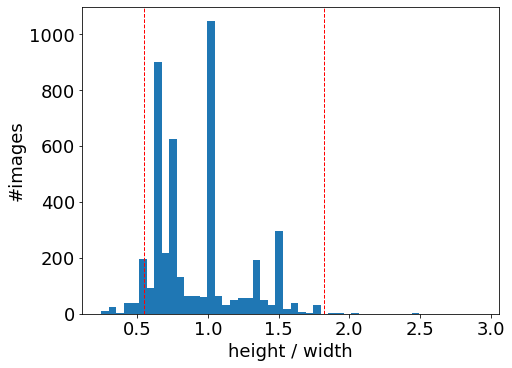

In [19]:
lower = 55/100
upper = 1/lower
mask = np.logical_and(ratio > lower, ratio < upper)
print(f"Von {len(shapes)} Bildern haben {len(shapes[mask])} ein Seitenverhältnis zwischen {lower} und {upper}")

fig, ax = plt.subplots()
ax.hist(ratio, bins=50, histtype="stepfilled")
ax.set(
    xlabel = "height / width",
    ylabel = "#images",
)
ax.axvline(x=lower, color="red", ls="--", lw=1)
ax.axvline(x=upper, color="red", ls="--", lw=1)
fig.savefig("data/ratio_hist_limits.pdf")

In [7]:
print("Die Indizes einiger sehr breiter Bilder:", np.where(ratio < lower))
print("Die Indizes einiger sehr hoher Bilder:", np.where(ratio > upper))

Die Indizes einiger sehr breiter Bilder: (array([   6,   18,   20,   23,   55,   79,   87,  125,  130,  131,  155,
        161,  166,  167,  174,  228,  266,  313,  323,  337,  350,  376,
        386,  395,  409,  411,  473,  476,  490,  502,  516,  518,  529,
        535,  577,  584,  620,  623,  624,  632,  637,  658,  676,  696,
        705,  729,  747,  780,  820,  849,  876,  883,  930,  980, 1050,
       1246, 1324, 1332, 1398, 1432, 1494, 1501, 1512, 1535, 1544, 1587,
       1589, 1649, 1722, 1733, 1775, 1799, 1802, 1838, 1840, 1853, 1891,
       1916, 1921, 1946, 1966, 1977, 1980, 1982, 1995, 1997, 2002, 2042,
       2048, 2071, 2075, 2209, 2290, 2381, 2421, 2453, 2529, 2533, 2549,
       2566, 2589, 2616, 2626, 2708, 2712, 2731, 2742, 2778, 2840, 2843,
       2867, 2881, 2918, 2978, 3026, 3045, 3046, 3048, 3066, 3080, 3098,
       3167, 3172, 3244, 3246, 3250, 3300, 3328, 3345, 3358, 3371, 3428,
       3471, 3506, 3515, 3661, 3697, 3718, 3747, 3814, 3975, 3980, 3983,
       40

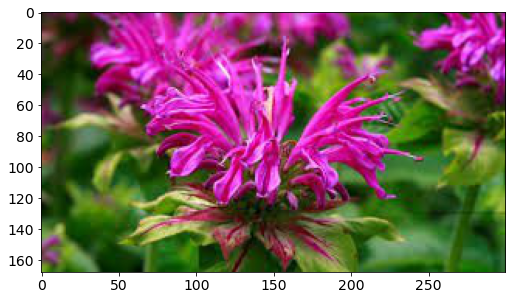

In [8]:
plt.imshow(images[198]);

In [9]:
# How to get size of image from a PIL Image object
testpath = path + f"{flowers[0]}"

for i, entry in enumerate(os.scandir(testpath)):
    if i == 129:
        im = Image.open(entry.path)
        print(im.getbbox()) #(left, upper, right, lower)

(0, 0, 294, 250)


# Resize images

In [10]:
img_rows = 200
img_cols = 200
shape_ord = (img_rows, img_cols, 3)

newpath = "data/Resized/"

if not os.path.isdir(newpath):
    os.mkdir(newpath)

for flower in flowers:
    if not os.path.isdir(newpath + flower):
        folder = newpath + flower
        os.mkdir(folder)
        for entry in os.scandir(path + f"{flower}/"):
            im = Image.open(entry.path)
            # only use images with: lower < ratio < upper
            ratio = im.getbbox()[3] / im.getbbox()[2] # height / width
            if ratio > lower and ratio < upper:
                im_r = im.resize((img_rows, img_cols), Image.ANTIALIAS)
                im_r.save(newpath + f"{flower}/" + entry.path.split("/")[-1])

### Save images as hdf5 files for faster IO

In [16]:
X = []
y = []
for i, flower in enumerate(flowers):
    counter = 0
    for entry in os.scandir(newpath + flower):
        X.append(np.array(Image.open(entry.path)))
        y.append(i)
        counter += 1
        if counter == 334: break

X = np.array(X)
y = np.array(y)
X.shape

(3674, 200, 200, 3)

In [17]:
for flower, count in zip(flowers, np.bincount(y)):
    print(flower, count)
    
print("\nDie kleinste Klasse war die BlanketFlower, die ", np.bincount(y).min(), " Instanzen hat.")

BeeBalm 334
Black-eyedSusan 334
BlanketFlower 334
BleedingHeart 334
ButterflyBush 334
Dahlia 334
FrangipaniFlower 334
GrapeHyacinth 334
MargueriteDaisy 334
Trillium 334
Waterlilies 334

Die kleinste Klasse hat  334  Instanzen.


In [18]:
# split 15% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

### Normalize to (0,1)

In [19]:
X_train = X_train.reshape(X_train.shape[0], img_rows * img_cols * 3)
X_test = X_test.reshape(X_test.shape[0], img_rows * img_cols * 3)
X_train.shape

(3122, 120000)

In [20]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape

(3122, 120000)

In [21]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
X_train.shape

(3122, 200, 200, 3)

In [22]:
for X_i, y_i, filename in zip([X_train, X_test], 
                          [y_train, y_test], 
                          ["images_resized_train", "images_resized_test"]):    
    with h5py.File(f"data/{filename}.h5", "w") as file:
        # Create a dataset in the file
        # -> create_dataset(key, shape, dtype, data)
        dataset = file.create_dataset(
            "images", np.shape(X_i), h5py.h5t.IEEE_F32BE, data=X_i
        )
        label_set = file.create_dataset(
            "labels", np.shape(y_i), h5py.h5t.STD_U8BE, data=y_i
        )

### Example input

In [23]:
# Open the HDF5 file
with h5py.File("data/images_resized_train.h5", "r") as file:
    images = np.array(file["/images"]).astype("float32")
    labels = np.array(file["/labels"]).astype("uint8")

images.shape, labels.shape

((3122, 200, 200, 3), (3122,))